In [1]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt

In [2]:
class ProcessingData:
    
    def __init__(self,filepath):
        with open(filepath, 'rb') as f:
            u = pickle._Unpickler(f)
            u.encoding = 'latin1'
            self.data = u.load()

    def fix_data(self, interval):
        """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
        converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
        don't have dt equal to interval.
        :param data:
        :param interval: float:minutes"""
        def f(x):
            if x == 0:
                return 0
            elif x == 2 or x == 5:
                return 2
            elif x ==1 or x == 3:
                return 1

        def h(x):
            if x == 1:
                return 1
            else:
                return 0

        def c(x):
            if x == 2:
                return 1
            else:
                return 0

        self.data["action"] = self.data["action"].map(f)
        self.data['action_heating'] = self.data["action"].map(h)
        self.data['action_cooling'] = self.data['action'].map(c)

        #print self.data.head()

        return self.data, self.data[self.data["dt"] == interval]
    
    def filter_data(self):
        self.data = self.data.drop(['dt', 'action', 'previous_action', 'action_duration', \
                                    'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1)
        return self.data
    
    def drop_nan(self):
        self.data = self.data.dropna()
        return self.data


In [3]:
training = ProcessingData("../../Data/avenal-animal-shelter_training_data.pkl")
training_data = training.fix_data(5)
training_data = training.filter_data()
training_data = training.drop_nan()
training_data.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling
time,,,,,,
2018-04-18 23:16:42+00:00,69.5,69.483333,66.499700,0.0,0,0
2018-04-18 23:21:42+00:00,69.5,69.500000,66.499700,0.0,0,0
2018-04-18 23:26:42+00:00,69.5,69.500000,66.520546,0.0,0,0
2018-04-18 23:31:42+00:00,69.4,69.500000,66.583083,0.0,0,0
2018-04-18 23:36:42+00:00,69.5,69.400000,66.666466,0.0,0,0


In [4]:
testing = ProcessingData("../../Data/avenal-animal-shelter_test_data.pkl")
testing_data = testing.fix_data(5)
testing_data = testing.filter_data()
testing_data = testing.drop_nan()
testing_data.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling
time,,,,,,
2018-03-20 00:00:00+00:00,72.8,72.8,67.778613,0.0,0,0
2018-03-20 00:05:00+00:00,73.0,72.8,67.807436,0.0,0,0
2018-03-20 00:10:00+00:00,73.0,73.0,67.835998,0.0,0,0
2018-03-20 00:15:00+00:00,73.0,73.0,67.864038,0.0,0,0
2018-03-20 00:20:00+00:00,73.0,73.0,67.891817,0.0,0,0


In [5]:
def scaling(data):
    maxValues = []
    scaled = np.empty([data.shape[0], data.shape[1]])
    numSamples = data.shape[0]
    numFeatures = data.shape[1]
    dataValues = data.values
    dataValues = dataValues.astype('float32')
    for i in range(numFeatures):
        maxNum = max(dataValues[:,i])
        maxValues.append(maxNum)
        for j in range(numSamples):
            scaled[j,i] = dataValues[j,i]/maxNum
    return scaled, maxValues

In [6]:
train_scaled, train_scalers = scaling(training_data)
train_scaled = pd.DataFrame(data=train_scaled, index=training_data.index, columns=['t_next', 't_in', 't_out', 'occ', 'action_heating', 'action_cooling'])
train_scaled.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling
time,,,,,,
2018-04-18 23:16:42+00:00,0.856967,0.856761,0.639420,0.0,0.0,0.0
2018-04-18 23:21:42+00:00,0.856967,0.856967,0.639420,0.0,0.0,0.0
2018-04-18 23:26:42+00:00,0.856967,0.856967,0.639621,0.0,0.0,0.0
2018-04-18 23:31:42+00:00,0.855734,0.856967,0.640222,0.0,0.0,0.0
2018-04-18 23:36:42+00:00,0.856967,0.855734,0.641024,0.0,0.0,0.0


In [7]:
test_scaled, test_scalers = scaling(testing_data)
test_scaled = pd.DataFrame(data=test_scaled, index=testing_data.index, columns=['t_next', 't_in', 't_out', 'occ', 'action_heating', 'action_cooling'])
test_scaled.head()

,t_next,t_in,t_out,occ,action_heating,action_cooling
time,,,,,,
2018-03-20 00:00:00+00:00,0.941785,0.941785,0.747789,0.0,0.0,0.0
2018-03-20 00:05:00+00:00,0.944373,0.941785,0.748107,0.0,0.0,0.0
2018-03-20 00:10:00+00:00,0.944373,0.944373,0.748422,0.0,0.0,0.0
2018-03-20 00:15:00+00:00,0.944373,0.944373,0.748731,0.0,0.0,0.0
2018-03-20 00:20:00+00:00,0.944373,0.944373,0.749038,0.0,0.0,0.0


In [8]:
trainY_df = train_scaled['t_next']
trainX_df = train_scaled.drop(['t_next'], axis=1)
trainX_df.head()

,t_in,t_out,occ,action_heating,action_cooling
time,,,,,
2018-04-18 23:16:42+00:00,0.856761,0.639420,0.0,0.0,0.0
2018-04-18 23:21:42+00:00,0.856967,0.639420,0.0,0.0,0.0
2018-04-18 23:26:42+00:00,0.856967,0.639621,0.0,0.0,0.0
2018-04-18 23:31:42+00:00,0.856967,0.640222,0.0,0.0,0.0
2018-04-18 23:36:42+00:00,0.855734,0.641024,0.0,0.0,0.0


In [9]:
testY_df = test_scaled['t_next']
testX_df = test_scaled.drop(['t_next'], axis=1)
testX_df.head()

,t_in,t_out,occ,action_heating,action_cooling
time,,,,,
2018-03-20 00:00:00+00:00,0.941785,0.747789,0.0,0.0,0.0
2018-03-20 00:05:00+00:00,0.941785,0.748107,0.0,0.0,0.0
2018-03-20 00:10:00+00:00,0.944373,0.748422,0.0,0.0,0.0
2018-03-20 00:15:00+00:00,0.944373,0.748731,0.0,0.0,0.0
2018-03-20 00:20:00+00:00,0.944373,0.749038,0.0,0.0,0.0


In [10]:
# split into input and outputs
train = train_scaled.values
test = test_scaled.values
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
train_y

array([ 0.85696673,  0.85696673,  0.85696673, ...,  0.85573369,
        0.85819978,  0.85943276])

In [11]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, 5))
test_X = test_X.reshape((test_X.shape[0], 1, 5))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(53186, 1, 5) (53186,) (13390, 1, 5) (13390,)


In [12]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [13]:
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 53186 samples, validate on 13390 samples
Epoch 1/50
 - 3s - loss: 0.0873 - acc: 3.3843e-04 - val_loss: 0.0258 - val_acc: 7.4683e-04
Epoch 2/50
 - 2s - loss: 0.0183 - acc: 3.3843e-04 - val_loss: 0.0254 - val_acc: 7.4683e-04
Epoch 3/50
 - 1s - loss: 0.0175 - acc: 3.3843e-04 - val_loss: 0.0250 - val_acc: 7.4683e-04
Epoch 4/50
 - 2s - loss: 0.0167 - acc: 3.3843e-04 - val_loss: 0.0240 - val_acc: 7.4683e-04
Epoch 5/50
 - 2s - loss: 0.0161 - acc: 3.3843e-04 - val_loss: 0.0253 - val_acc: 7.4683e-04
Epoch 6/50
 - 2s - loss: 0.0160 - acc: 3.3843e-04 - val_loss: 0.0282 - val_acc: 7.4683e-04
Epoch 7/50
 - 1s - loss: 0.0158 - acc: 3.3843e-04 - val_loss: 0.0285 - val_acc: 7.4683e-04
Epoch 8/50
 - 1s - loss: 0.0157 - acc: 3.3843e-04 - val_loss: 0.0285 - val_acc: 7.4683e-04
Epoch 9/50
 - 2s - loss: 0.0155 - acc: 3.3843e-04 - val_loss: 0.0280 - val_acc: 7.4683e-04
Epoch 10/50
 - 1s - loss: 0.0153 - acc: 3.3843e-04 - val_loss: 0.0283 - val_acc: 7.4683e-04
Epoch 11/50
 - 2s - loss: 0.0150 - acc:

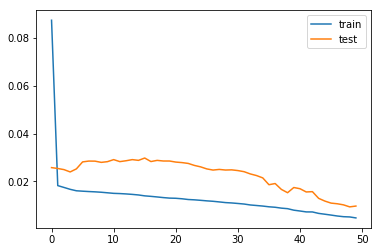

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [15]:
yhat = model.predict(test_X)
yhat

array([[ 0.92542201],
       [ 0.92543244],
       [ 0.92745638],
       ..., 
       [ 0.92850798],
       [ 0.92949677],
       [ 0.93048561]], dtype=float32)

In [16]:
maxT_in = max(testing_data['t_in'])
maxT_in

77.299999999999997

In [17]:
inv_yhat = np.array([])
for y in yhat:
    inv_yhat = np.append(inv_yhat, y*maxT_in)
inv_yhat

array([ 71.53512573,  71.53593445,  71.69238281, ...,  71.77366638,
        71.85010529,  71.92653656])

In [18]:
inv_y = np.array([])
for y in test_y:
    inv_y = np.append(inv_y, y*maxT_in)
inv_y

array([ 72.80000183,  72.99999694,  72.99999694, ...,  72.39999779,
        72.49999765,  72.49999765])

In [19]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.155


In [20]:
def forecasting(testX_df, testY_df, start_time, duration, model, maxT_in):
    predictions_i = []
    errs_i = []
    curr_time = start_time
    end_time = start_time + datetime.timedelta(minutes=duration)
    while curr_time <= end_time:
        if curr_time not in testX_df.index:
            #print("Not present")
            return None
        input_x = testX_df.loc[curr_time].copy()
        if predictions_i:
            input_x['t_in'] = predictions_i[-1]
        inputX_values = input_x.values
        inputX_values = inputX_values.reshape(1,1,5)
        y = model.predict([inputX_values])
        predictions_i.append(y[0])
        errs_i.append(testY_df.loc[curr_time]*maxT_in - y[0]*maxT_in)
        curr_time = curr_time + datetime.timedelta(minutes=5)
    #print(predictions_i)
    #print(errs_i)
    return errs_i

In [21]:
predictions = []
errs = []
startSamples = testX_df.sample(n=800)
startList = startSamples.index
duration = 60 * 6
for start in startList:
    errs_i = forecasting(testX_df, testY_df, start, duration, model, maxT_in)
    #predictions.append(pd.Series(index=range(len(predictions_i)), data=predictions_i))
    if errs_i:
        errs.append(pd.Series(index=range(len(errs_i)), data=errs_i))
#print(predictions)
#print(errs)

[0.8838983822823677, 1.57091281659007, 2.11430158494782, 2.5533941168872527, 2.90365593079098, 3.1717244088874192, 3.3818256834479623, 3.5495556466129696, 3.6853027977294106, 3.7926114035546328, 3.87875189970797, 3.9466834250014435, 3.9921786479565204, 4.0339644870113105, 4.070119068616788, 4.083530671811955, 4.099191251700999, 4.1095804087229, 4.120374266469062, 4.129455389605992, 4.134174651090525, 4.1417553511938054, 4.143803237716907, 4.141769909969189, 4.150632703162119, 4.152270344210012, 4.152446992214217, 4.1577125720962105, 4.157105334003125, 4.156162536755878, 4.155823498486797, 4.1532026555872195, 4.149619554013925, 4.151835400772746, 4.152694384122193, 4.151325815140546, 4.144331795709999, 4.138849238582043, 4.142447935115575, 4.1388061029933825, 4.135775227447563, 4.133695831416546, 4.135776331951901, 4.131834550376214, 4.134423056805808, 4.135573365530905, 4.136216105168952, 4.138145590424133, 4.137283628315556, 4.1450523834970125, 4.146040295118335, 4.155168707753281, 4.

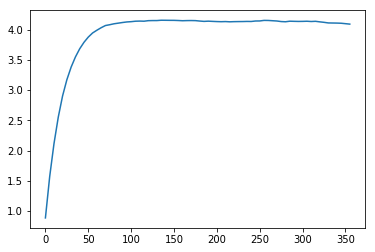

In [22]:
final_errors = []
for i in range(int(duration/5)):
    ei = np.array([])
    for e in errs:
        ei = np.append(ei, e.loc[i]*e.loc[i])
    final_errors.append(sqrt(np.mean(ei)))
#final_errors = pd.Series(index=range(len(final_errors)), data = final_errors)
print(final_errors)
timesteps = [x*5 for x in range(len(final_errors))]
plt.plot(timesteps,final_errors)
plt.show()